In [5]:
links = ['https://www.imdb.com/search/title/?release_date=2010-01-01,&sort=boxoffice_gross_us,desc&count=250&start={}'.format(i) for i in range(1,5000,250)]

 

In [12]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

Sorry for the long function, I worked a little backwards. I created all these variables on a different notebook for page 1. Bunched them together here for the sake of grabbing multiple pages


In [62]:
def page_contents(link):
    imdb_html = requests.get(link)
    soup = BeautifulSoup(imdb_html.content, 'html.parser')
    main_div_tag = soup.find('div', {'class':'lister-list'})
    movies_per_page = main_div_tag.find_all('div', {'class':'lister-item mode-advanced'})
    contents = []
    for item in movies_per_page:
        contents.append(item.find('div',{'class':'lister-item-content'}))
    movie_ids =[]
    for i in contents:
        movie_ids.append(i.find('h3').find('a')['href'].split('/')[2])
    movie_titles =[]
    for i in contents:
        movie_titles.append(str(i.find('h3').find('a')).split('>')[1].split('<')[0])
    years =[]
    for i in contents:
        year = str(i.find('h3').find('span', {'class':'lister-item-year text-muted unbold'})).split('(')[-1].split(')')[0]
        years.append(int(year))
    ratings =[]
    for i in contents:
        ratings.append(str(i.find('p').find('span',{'class':'certificate'})).split('>')[1].split('<')[0])
    runtimes =[]
    for i in contents:
        runtimes.append(str(i.find('p').find('span',{'class':'runtime'})).split('>')[1].split('<')[0].split()[0])
    genres = []
    for i in contents:
        clean_genre = []
        genres_unclean = str(i.find('p').find('span',{'class':'genre'})).split('>')[1].split('<')[0].split('\n')[1].split(',')
        for genr in genres_unclean:
            clean_genre.append(genr.strip())
        genres.append(clean_genre)
    imdb_rating = []
    for i in contents:
        imdb_rating.append(float(i.find('div',{'class':'inline-block ratings-imdb-rating'})['data-value']))
    meta_score_rating = []
    for i in contents:
        score = str(i.find('div',{'class':'inline-block ratings-metascore'}).find('span')).split('>')[1].split('<')[0].strip()
        meta_score_rating.append(int(score))
    votes =[]
    for i in contents:
        votes.append(int(str(i.find('p', {'class':'sort-num_votes-visible'}).find_all('span')[1]).split('>')[1].split('<')[0].replace(',','')))
    gross_rev =[]
    for i in contents:
        gross_rev.append(int(str(i.find('p',{'class':'sort-num_votes-visible'}).find_all('span')[4]).split('"')[1].replace(',','')))
    def get_text_from_a(a_tag):
        '''
        takes a 'a' tag argument from html and returns the text displayed
        '''
        return str(a_tag).split('>')[1].split('<')[0]
    directors =[]
    for i in contents:
        dirct =[]
        for i2 in i.find('p',{'class':''}):
            if i2 == i.find('p',{'class':''}).find('span'):
                break
            else:
                if i2 in i.find('p',{'class':''}).find_all('a'):
                    dirct.append(get_text_from_a(i2))
        directors.append(dirct)
    def get_stars(content):
        strz =[]
        for i2 in content.find('p',{'class':''}):
            if i2 in content.find('p',{'class':''}).find_all('a'):
                strz.append(get_text_from_a(i2))
            else:
                if i2 == content.find('p',{'class':''}).find('span'):
                    strz = []
                    continue
        return strz
    
    stars = [get_stars(i) for i in contents] 
    
    return pd.DataFrame({'id':movie_ids,'title':movie_titles,     
    'year':years,'ratings':ratings,'runtime':runtimes,
    'genre':genres,'imdb_rating':imdb_rating,
    'meta_score':meta_score_rating,
    'votes':votes,'revenue':gross_rev,
    'directors':directors,'stars':stars})

My function only worked for the first two pages..

In [63]:
# list of 2 dataframes
multiple_df = [page_contents(link) for link in links[:2]]

In [69]:
# combining dataframes into one
df = pd.concat(multiple_df,ignore_index=True)

In [71]:
# creating csv
df.to_csv('top_500_academy_winning_movies_by_box_office_2010-2020.csv')

In [119]:
df.head()

,id,title,year,ratings,runtime,genre,imdb_rating,meta_score,votes,revenue,directors,stars,num_of_stars,num_of_directors
0,tt2488496,Star Wars: Episode VII - The Force Awakens,2015,PG-13,138,"[Action, Adventure, Sci-Fi]",7.9,81,827705,936662225,[J.J. Abrams],"[Daisy Ridley, John Boyega, Oscar Isaac, Domhn...",4,1
1,tt4154796,Avengers: Endgame,2019,PG-13,181,"[Action, Adventure, Drama]",8.5,78,675448,858373000,"[Anthony Russo, Joe Russo]","[Robert Downey Jr., Chris Evans, Mark Ruffalo,...",4,2
2,tt1825683,Black Panther,2018,PG-13,134,"[Action, Adventure, Sci-Fi]",7.3,88,566449,700059566,[Ryan Coogler],"[Chadwick Boseman, Michael B. Jordan, Lupita N...",4,1
3,tt4154756,Avengers: Infinity War,2018,PG-13,149,"[Action, Adventure, Sci-Fi]",8.5,68,750737,678815482,"[Anthony Russo, Joe Russo]","[Robert Downey Jr., Chris Hemsworth, Mark Ruff...",4,2
4,tt0369610,Jurassic World,2015,PG-13,124,"[Action, Adventure, Sci-Fi]",7.0,59,557059,652270625,[Colin Trevorrow],"[Chris Pratt, Bryce Dallas Howard, Ty Simpkins...",4,1


In [94]:
df['num_of_stars'] = df['stars'].map(lambda x: len(x))

In [96]:
df['num_of_directors'] = df['directors'].map(lambda x: len(x))

In [99]:
df[['directors','num_of_directors']]

,directors,num_of_directors
0,[J.J. Abrams],1
1,"[Anthony Russo, Joe Russo]",2
2,[Ryan Coogler],1
3,"[Anthony Russo, Joe Russo]",2
4,[Colin Trevorrow],1
...,...,...
495,[Nicholas Stoller],1
496,[Harold Cronk],1
497,[M. Night Shyamalan],1
498,[Scott Hicks],1


In [106]:
# list of directors and the count of how many movies they directed (in the dataset)
director_count ={}
for directors in df.directors:
    for director in directors:
        director_count[director] = director_count.get(director, 1) + 1

In [107]:
import matplotlib.pyplot as plt
%matplotlib inline

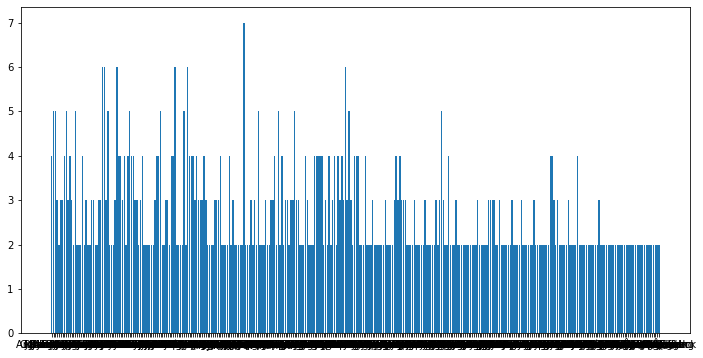

In [118]:
plt.figure(figsize=(12,6));
plt.bar(director_count.keys(),director_count.values());
plt.show()

In [ ]:
for 